## Library imports

In [ ]:
azure = False
colab = False

if azure or colab:
    !pip install seqeval
    !pip install git+https://www.github.com/keras-team/keras-contrib.git
    !pip install plot_keras_history
    !pip install fasttext

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer
from tensorflow.keras import optimizers
from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics
from plot_keras_history import plot_history

from prettytable import PrettyTable

Using TensorFlow backend.


In [4]:
print(keras.backend.backend())

tensorflow


In [6]:
# For Google Colab only
if colab:
    !git clone https://github.com/mapriess/GermEval_2014_NER_DEMO.git

## Data: Import

In [7]:
#
# Parser for GermEval 2014 Dataset
#
# Input: Tab-separated file, one token per row, two levels of annotation
# Token    Tag_Level1     Tag_Level2
# 
# Output: Pandas dataframe (columns: Sentence #, Token, TagComb)
#
def parser(path):
    cols = ['Sentence #','Word', 'Tag_Level1', 'Tag_Level2']
    df = pd.read_csv(path, sep='\t', encoding="utf8", quoting=3)

    # Set columns
    cols = ['Sentence #','Word', 'Tag_Level1', 'Tag_Level2']
    df.set_axis(labels=cols, axis='columns', inplace=True)

    # Correct sentence number according to source entries (#)
    # TODO: Find more efficient way to further speed up the parsing
    sent_id = 1
    for index, row in df.iterrows():
        if (row['Sentence #'] == '#'):
            sent_id += 1
            continue
        row['Sentence #'] = "Sentence: " + str(sent_id)

    # Delete rows starting with '#'
    df.drop( df[df['Sentence #'] == '#'].index, inplace=True )

    # Conventional flat named‐entity‐recognition models could be used without any modification once the labels of different levels were joined together into a single level (Agrawal et al. (2022)).
    df['TagComb'] = df['Tag_Level1'] + "+" + df['Tag_Level2']
    df.drop(columns=['Tag_Level1','Tag_Level2'], inplace=True)

    return df

In [8]:
pathColab = ''
if colab:
  pathColab = "GermEval_2014_NER_DEMO/"

df_train = parser(pathColab + "Data/NER-de-train.tsv")
df_val = parser(pathColab + "Data/NER-de-dev.tsv")
df_test = parser(pathColab + "Data/NER-de-test.tsv")
df = parser(pathColab + "Data/NER-de-all.tsv") # TODO: Can also be achieved through concatenation of DFs

## Data: Inspection

In [10]:
print(df_train.shape,df_val.shape,df_test.shape,df.shape)

(452853, 3) (41653, 3) (96499, 3) (591005, 3)


In [11]:
# DF overview
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591005 entries, 0 to 622303
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentence #  591005 non-null  object
 1   Word        590999 non-null  object
 2   TagComb     591005 non-null  object
dtypes: object(3)
memory usage: 18.0+ MB
None


<AxesSubplot:>

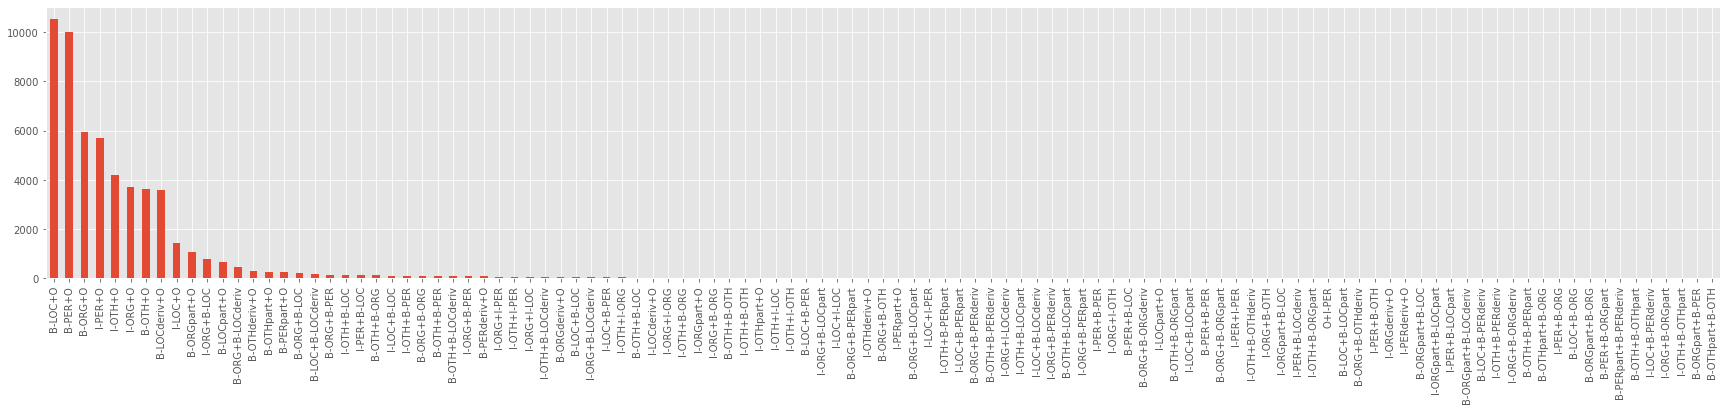

In [12]:
# NER tag distribution
df[df["TagComb"]!="O+O"]["TagComb"].value_counts().plot(kind="bar", figsize=(30,5))

In [13]:
# Occurrence of combined tag "I-OTH+I-LOC"
df[df["TagComb"]=="I-OTH+I-LOC"]

,Sentence #,Word,TagComb
36901,Sentence: 1865,England,I-OTH+I-LOC
69076,Sentence: 3496,Lorenzo,I-OTH+I-LOC
72454,Sentence: 3667,.,I-OTH+I-LOC
72455,Sentence: 3667,Hedwigskirche,I-OTH+I-LOC
222580,Sentence: 11234,Oranienburg,I-OTH+I-LOC
265093,Sentence: 13389,Meeres,I-OTH+I-LOC
337843,Sentence: 17035,Big,I-OTH+I-LOC
337844,Sentence: 17035,Horn,I-OTH+I-LOC
347724,Sentence: 17500,Charlie,I-OTH+I-LOC
356374,Sentence: 17933,Nam,I-OTH+I-LOC


In [14]:
# NER tag distribution
df['TagComb'].value_counts()

O+O                     535985
B-LOC+O                  10522
B-PER+O                  10022
B-ORG+O                   5939
I-PER+O                   5710
                         ...  
I-OTH+B-PERderiv             1
I-ORGderiv+O                 1
B-LOC+B-ORG                  1
I-PER+B-LOCpart              1
B-ORGpart+B-LOCderiv         1
Name: TagComb, Length: 110, dtype: int64

In [15]:
# Sentence length distribution
df['Sentence #'].value_counts()

Sentence: 15371    56
Sentence: 5900     52
Sentence: 31063    51
Sentence: 19927    51
Sentence: 24993    50
                   ..
Sentence: 7822      4
Sentence: 7036      4
Sentence: 16982     3
Sentence: 15419     3
Sentence: 900       3
Name: Sentence #, Length: 31300, dtype: int64

In [16]:
# List of unique words
words = list(set(df['Word'].values))
words.append('PADword') # later used for creating input vectors of fixed length (padding)
n_words = len(words)
print("Number of unique words in dataset:", n_words)

Number of unique words in dataset: 89946


In [17]:
# List of unique (combined) tokens
tags = list(set(df["TagComb"].values))
n_tags = len(tags)
print("Number of unique tags in dataset:", n_tags)

Number of unique tags in dataset: 110


In [18]:
# Check null elements
df.isnull().sum(axis = 0)

Sentence #    0
Word          6
TagComb       0
dtype: int64

**Conclusion:**

We have 31300 sentences in our training dataset, 89946 different words and 110 different named entities (Tags).

## Data: Preparation

In [19]:
#
# Input: Pandas dataframe (columns: Sentence #, Token, TagComb)
# Output: list of tuples [(word, named entity tag), ...]
#
def createSentenceList(df):
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["TagComb"].values.tolist())]
    grouped = df.groupby("Sentence #").apply(agg_func)
    sentences = [s for s in grouped] 
    return sentences

In [20]:
sentences_df = createSentenceList(df)
sentences_df_train = createSentenceList(df_train)
sentences_df_val = createSentenceList(df_val)
sentences_df_test = createSentenceList(df_test)

print("# sentences complete dataset: ", len(sentences_df))
print("# sentences train dataset: ", len(sentences_df_train))
print("# sentences val dataset: ", len(sentences_df_val))
print("# sentences test dataset: ", len(sentences_df_test))

# sentences complete dataset:  31300
# sentences train dataset:  24000
# sentences val dataset:  2200
# sentences test dataset:  5100


In [21]:
# Get first sentence
print( "Train: " + str(sentences_df_train[0]) + "\n" )
print( "Val: " + str(sentences_df_val[0]) + "\n" )
print( "Test: " + str(sentences_df_test[0]))

Train: [('Schartau', 'B-PER+O'), ('sagte', 'O+O'), ('dem', 'O+O'), ('"', 'O+O'), ('Tagesspiegel', 'B-ORG+O'), ('"', 'O+O'), ('vom', 'O+O'), ('Freitag', 'O+O'), (',', 'O+O'), ('Fischer', 'B-PER+O'), ('sei', 'O+O'), ('"', 'O+O'), ('in', 'O+O'), ('einer', 'O+O'), ('Weise', 'O+O'), ('aufgetreten', 'O+O'), (',', 'O+O'), ('die', 'O+O'), ('alles', 'O+O'), ('andere', 'O+O'), ('als', 'O+O'), ('überzeugend', 'O+O'), ('war', 'O+O'), ('"', 'O+O'), ('.', 'O+O')]

Val: [('Gleich', 'O+O'), ('darauf', 'O+O'), ('entwirft', 'O+O'), ('er', 'O+O'), ('seine', 'O+O'), ('Selbstdarstellung', 'O+O'), ('"', 'O+O'), ('Ecce', 'B-OTH+O'), ('homo', 'I-OTH+O'), ('"', 'O+O'), ('in', 'O+O'), ('enger', 'O+O'), ('Auseinandersetzung', 'O+O'), ('mit', 'O+O'), ('diesem', 'O+O'), ('Bild', 'O+O'), ('Jesu', 'B-PER+O'), ('.', 'O+O')]

Test: [('1951', 'O+O'), ('bis', 'O+O'), ('1953', 'O+O'), ('wurde', 'O+O'), ('der', 'O+O'), ('nördliche', 'O+O'), ('Teil', 'O+O'), ('als', 'O+O'), ('Jugendburg', 'O+O'), ('des', 'O+O'), ('Kolpingw

In [22]:
# Determine largest sentence
largest_sen = max(len(sen) for sen in sentences_df)
print('Biggest sentence has {} words'.format(largest_sen))

Biggest sentence has 56 words


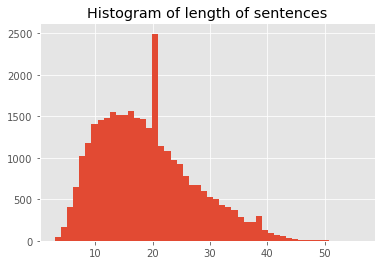

In [23]:
# Histogram of length of sentences
%matplotlib inline
plt.hist([len(sen) for sen in sentences_df], bins= 50)
plt.title("Histogram of length of sentences")
plt.show()

**Conclusion:**

The longest sentence has 56 words in it and we can see that almost all of the sentences have less than 50 words in them.

In [24]:
# Assigning index to all unique words and tags
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}

# Print index for exemplary word and tag
print(words2index['Tagesspiegel'])
print(tags2index['B-LOC+B-PER'])

87572
11


In [25]:
# Visualise words to index and vice versa mappings
df['Word_idx'] = df['Word'].map(words2index)
df['Tag_idx'] = df['TagComb'].map(tags2index)
df.head()

,Sentence #,Word,TagComb,Word_idx,Tag_idx
0,Sentence: 1,Schartau,B-PER+O,89087,74
1,Sentence: 1,sagte,O+O,69356,49
2,Sentence: 1,dem,O+O,40357,49
3,Sentence: 1,"""",O+O,27793,49
4,Sentence: 1,Tagesspiegel,B-ORG+O,87572,62


### Load FastText model (Facebook)

In [26]:
import fasttext 
import fasttext.util

fasttext.util.download_model("de", if_exists="ignore")
ft_model = fasttext.load_model("cc.de.300.bin")

### Apply FastText embeddings of shape (#sent, max_len, 300) for x values

In [106]:
# Here we need to add the FastText representations as embeddings.
# Before, only the index of words were used as embeddings. We now use the ft method 'get_word_vector' to get the vector representation
max_len = 50    

def word_to_fasttext_embedding(w):
    try:
        return ft_model.get_word_vector(w[0])
    except Exception:
        return

def convert_words_to_fasttext_embedding(dataframe_with_sentences):
    # ft_embed_s: list of dim (#sent, #words, 300)
    ft_embed_s = [[word_to_fasttext_embedding(w) for w in s] for s in dataframe_with_sentences] 
    
    # Created padded Embedding of shape (#sent, max_len, 300)
    for index, sA in enumerate(ft_embed_s):
        # sA:           list of dim (#words, 300)
        # needed_pads:  list of dim (#paddings, 300)
        # paddedEmb:    list of dim (max_len, 300), where max_len = #words + #paddings
        needed_pads = [np.zeros(300) for i in range(max_len - len(sA))]
        paddedEmb = np.array(sA + needed_pads)
        ft_embed_s[index] = np.array(paddedEmb)

    # Delete sentences with length >= max_len
    missshaped_data = []
    for index, sA in enumerate(ft_embed_s):
        if sA.shape != (max_len, 300):
            missshaped_data.append(index)
            del ft_embed_s[index]

    return (np.stack(ft_embed_s), missshaped_data)

X_tr, missshaped_X_tr = convert_words_to_fasttext_embedding(sentences_df_train)
X_val, missshaped_X_val = convert_words_to_fasttext_embedding(sentences_df_val)
X_te, missshaped_X_te = convert_words_to_fasttext_embedding(sentences_df_test)

/Applications/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# OLD
# X_val = [[apply_func(w) for w in s] for s in sentences_df_val]
# X_te = [[apply_func(w) for w in s] for s in sentences_df_test]

# for index, sA in enumerate(X_val):
#     neededPads = [np.zeros(300) for i in range(max_len - len(sA))]
#     X_val[index] = np.array(sA + neededPads)

# for index, sA in enumerate(X_te):
#     neededPads = [np.zeros(300) for i in range(max_len - len(sA))]
# #     X_te[index] = np.array(sA + neededPads)

# missshaped_X_tr = []
# missshaped_X_val = []
# missshaped_X_te = []

# for index, sA in enumerate(X_val):
#     if sA.shape != (max_len, 300):
#         missshaped_X_val.append(index)
#         del X_val[index]

# for index, sA in enumerate(X_te):
#     if sA.shape != (max_len, 300):
#         missshaped_X_te.append(index)
#         del X_te[index]


#X_tr = np.stack(X_tr)
#X_te = np.stack(X_te)
#X_val = np.stack(X_val)

#Array Shape = (24000, WordSentences, 300)
# X_tr = [[words2index[w[0]] for w in s] for s in sentences_df_train]
# X_val = [[words2index[w[0]] for w in s] for s in sentences_df_val]
# X_te = [[words2index[w[0]] for w in s] for s in sentences_df_test]
# Padding sentences to make the length of all sentences same
#X_tr = np.pad(X_tr, ((0,0), (0, max_len-len(X_tr[1])), (0,0)), constant_value=np.zeros(300))
#print(X_tr.shape)
#X_tr = pad_sequences(maxlen=max_len, sequences=X_tr, padding="post", value=np.zeros(300, type=np.float32)) #padding needs to be a vector with 0 values 
                                                                              # and with the same dimension as the fasttext embeddings
#X_val = pad_sequences(maxlen=max_len, sequences=X_val, padding="post", value=np.zeros(300))
#X_te = pad_sequences(maxlen=max_len, sequences=X_te, padding="post", value=np.zeros(300))

# Check first data samples
#print("Val: " + str(X_val[0]) + "\n")
#print("Test: " + str(X_te[0]))

In [107]:
# Test: FT Embedding of first word in first sentence
X_tr[0][0]

array([ 0.0664457 , -0.03656383,  0.0119414 , -0.03504815,  0.03190385,
        0.06359198, -0.00625028,  0.0457193 ,  0.10235862,  0.09123483,
       -0.00682202, -0.0141362 , -0.02939142,  0.00659941, -0.09507381,
       -0.01389073,  0.13451397,  0.0758681 , -0.04472874,  0.01333077,
       -0.06154153,  0.01087625,  0.01481687,  0.01289295,  0.07463939,
        0.05905278,  0.01544696,  0.0619128 , -0.01057515, -0.06313283,
       -0.05923801, -0.05121872, -0.06222444, -0.02596068, -0.07995718,
        0.0380957 , -0.00053346,  0.01976248, -0.02147406, -0.10131035,
       -0.06297116,  0.03298582,  0.01992661,  0.00480682,  0.01516139,
        0.0179726 , -0.02184531, -0.02485196, -0.05015184, -0.0234892 ,
        0.02152821, -0.01098075, -0.05296443,  0.02732234, -0.0450508 ,
        0.05922005, -0.05917516,  0.08912266,  0.06538949, -0.00194373,
        0.01022126,  0.00495855, -0.04361581,  0.02899145,  0.02484912,
       -0.01551252,  0.03914731,  0.00431881,  0.01779194,  0.05

In [108]:
# Test: FT Embedding of word #25 (= pad word) in first sentence => should be zero embedding
X_tr[0][25]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [111]:
print(X_tr.shape)
print(X_val.shape)
print(X_te.shape)

(23992, 50, 300)
(2199, 50, 300)
(5099, 50, 300)


### Apply index embeddings (+ categorical transformation) of shape (#sent, max_len, #tags) for y values

In [113]:
# Convert tags to indices defining input vector y of shape (#sentences, max_len, #tags) with max_len = 50 in this case
y_tr = [[tags2index[w[1]] for w in s] for s in sentences_df_train]
y_val = [[tags2index[w[1]] for w in s] for s in sentences_df_val]
y_te = [[tags2index[w[1]] for w in s] for s in sentences_df_test]

# Delete data sets that have sentence length >= max_len
for index in missshaped_X_te:
    del y_te[index]

for index in missshaped_X_val:
    del y_val[index]
    
for index in missshaped_X_tr:
    del y_tr[index]

# Shapes have to correspond to x-inputs
print(len(y_tr) == X_tr.shape[0])
print(len(y_val) == X_val.shape[0])
print(len(y_te) == X_te.shape[0])

# Padding tags to match length of sentence
y_tr = pad_sequences(maxlen=max_len, sequences=y_tr, padding="post", value=tags2index["O+O"])
y_val = pad_sequences(maxlen=max_len, sequences=y_val, padding="post", value=tags2index["O+O"])
y_te = pad_sequences(maxlen=max_len, sequences=y_te, padding="post", value=tags2index["O+O"])

# Make y categorical (#sentences, max_len, #tags)
y_tr = [to_categorical(i, num_classes=n_tags) for i in y_tr]
y_val = [to_categorical(i, num_classes=n_tags) for i in y_val]
y_te = [to_categorical(i, num_classes=n_tags) for i in y_te]

# Check first data samples
print("Train: " + str(y_tr[0]) + "\n")
print("Val: " + str(y_val[0]) + "\n")
print("Test: " + str(y_te[0]))

True
True
True
Train: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Val: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Test: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Model: Defining architecture

In [122]:
# Defining model architecture
TAG_COUNT       = n_tags
LSTM_UNITS      = 50
LSTM_DROPOUT    = 0.1
DENSE_UNITS     = 50

tf.compat.v1.set_random_seed(32)

# Using keras Sequential approach
model = keras.Sequential()
model.add(InputLayer(input_shape=(X_tr[0].shape))) #new ft input dim (max_len, 300)
model.add(Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True, recurrent_dropout=LSTM_DROPOUT)))
model.add(TimeDistributed(Dense(DENSE_UNITS, activation="relu")))
model.add(CRF(TAG_COUNT, learn_mode = 'join', test_mode = 'viterbi')) 

In [123]:
loss = losses.crf_loss
# acc_metric = metrics.crf_accuracy
acc_metric = metrics.crf_viterbi_accuracy
opt = optimizers.Adam(lr=0.002)
# opt = optimizers.RMSprop(lr=0.001)

model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

In [124]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 50, 100)           140400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 50, 110)           17930     
Total params: 163,380
Trainable params: 163,380
Non-trainable params: 0
_________________________________________________________________


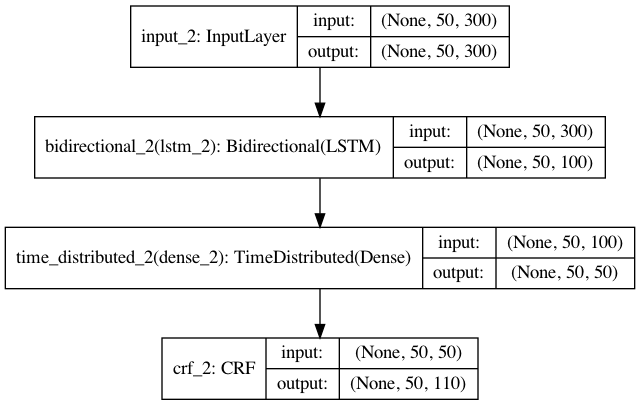

In [125]:
plot_model(model,'model.png',show_shapes= True)

## Model: Training + Validation

In [126]:
BATCH_SIZE = 64
EPOCHS = 12

history = model.fit(X_tr, np.array(y_tr), validation_data=(X_val, np.array(y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Train on 23992 samples, validate on 2199 samples
Epoch 1/12
23992/23992 [==============================] - 109s 5ms/step - loss: 0.3091 - crf_viterbi_accuracy: 0.9517 - val_loss: 0.0897 - val_crf_viterbi_accuracy: 0.9734
Epoch 2/12
23992/23992 [==============================] - 95s 4ms/step - loss: 0.0592 - crf_viterbi_accuracy: 0.9783 - val_loss: 0.0382 - val_crf_viterbi_accuracy: 0.9804
Epoch 3/12
23992/23992 [==============================] - 94s 4ms/step - loss: 0.0217 - crf_viterbi_accuracy: 0.9826 - val_loss: 0.0098 - val_crf_viterbi_accuracy: 0.9834
Epoch 4/12
23992/23992 [==============================] - 97s 4ms/step - loss: -0.0042 - crf_viterbi_accuracy: 0.9845 - val_loss: -0.0130 - val_crf_viterbi_accuracy: 0.9845
Epoch 5/12
23992/23992 [==============================] - 94s 4ms/step - loss: -0.0252 - crf_viterbi_accuracy: 0.9856 - val_loss: -0.0329 - val_crf_viterbi_accuracy: 0.9859
Epoch 6/12
23992/23992 [==============================] - 99s 4ms/step - loss: -0.0439 - cr

In [127]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,0.089674,0.973429,0.309121,0.951651
1,0.038188,0.980373,0.059228,0.978290
2,0.009823,0.983374,0.021720,0.982630
3,-0.013040,0.984524,-0.004192,0.984531
4,-0.032906,0.985851,-0.025188,0.985633
5,-0.051579,0.986338,-0.043943,0.986282
6,-0.068338,0.986244,-0.061947,0.986913
7,-0.083996,0.986481,-0.079241,0.987416
8,-0.100734,0.986952,-0.096072,0.987940
9,-0.116686,0.987181,-0.112737,0.988374


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'CRF viterbi Accuracy'}, xlabel='Epochs', ylabel='CRF viterbi Accuracy'>],
       dtype=object))

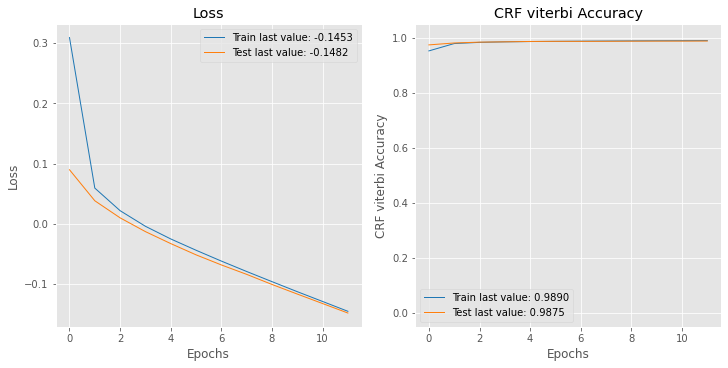

In [128]:
plot_history(history.history)

## Model: Prediction for test data

In [129]:
# Predict output for test data
test_pred = model.predict(X_te, verbose=1)
# Index as key and tag as value
idx2tag = {i: w for w, i in tags2index.items()}
# Function to convert indexed tags to corresponding actual tags
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

5099/5099 [==============================] - 8s 2ms/step


In [130]:
print("Accuracy: ", accuracy_score(test_labels, pred_labels))

Accuracy:  0.9877073936065895


In [132]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 73.4%


In [133]:
print(classification_report(test_labels, pred_labels))

/Applications/anaconda3/envs/tf1/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

         LOC+B-LOC       0.29      0.06      0.11        31
    LOC+B-LOCderiv       0.60      0.36      0.45        42
         LOC+B-PER       0.00      0.00      0.00        15
    LOC+B-PERderiv       0.00      0.00      0.00         1
     LOC+B-PERpart       0.00      0.00      0.00         1
         LOC+I-LOC       0.00      0.00      0.00         2
             LOC+O       0.78      0.84      0.81      1710
        LOCderiv+O       0.86      0.85      0.85       561
         LOCpart+O       0.30      0.03      0.05       109
         ORG+B-LOC       0.68      0.69      0.68       140
    ORG+B-LOCderiv       0.62      0.68      0.65        81
     ORG+B-LOCpart       0.00      0.00      0.00         4
         ORG+B-ORG       0.00      0.00      0.00        10
    ORG+B-ORGderiv       0.00      0.00      0.00         1
         ORG+B-PER       0.56      0.38      0.45        24
    ORG+B-PERderiv       0.00      0.00

# This code wont work under fasttext since we are not able to convert the embeddings back into words

In [ ]:
# Output for random test input
# Wont work with fasttext! Vector Embeddings cannot be converted to old word
i = 40
print(ft_model.(X_te[i][i]))

p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

    
x = PrettyTable()
x.field_names = ["Word", "Actual Tag", "Predicted Tag"]

for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        # x.add_row([words[w-1], tags[t], tags[pred]])
        x.add_row([words[w], tags[t], tags[pred]])
        
print(x)

### Visualising in spacy

In [ ]:
sen = ''
for s in sentences_df_test[40]:
  sen += s[0] + ' '
sen

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('de_core_news_sm')
text = nlp(sen)
displacy.render(text, style = 'ent', jupyter=True)

In [ ]:
# Query sentence other than test input
test_sentence = ["Berlin", "ist", "die", "Hauptstadt", "von", "Deutschland", "und", "Bayern", "München", "ist", "ein", "deutscher", "Fußballclub"]

In [ ]:
x_test_sent = pad_sequences(sequences=[[words2index.get(w, 0) for w in test_sentence]], padding="post", value=0, maxlen=max_len)

In [ ]:
# Output tags for query input
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)

x = PrettyTable()
x.field_names = ["Word", "Predicted Tag"]

for w, pred in zip(test_sentence, p[0]):
    x.add_row([w, tags[pred]])
        
print(x)